# Convolutional RBM on the GPU (cRBM)
In this notebook, a general implementation of the convolutional Restricted Boltzmann Machine is given.
The code focusses on speed on GPUs (graphics cards) and therefore, the relevant parts are written in Theano.

The first parts of the notebook provide methods to read in the DNA sequences while the actual training algorithm is given in section 3.


## Part 0: Importing all relevant packages

In [1]:
%matplotlib inline

# Theano imports
import theano
import theano.tensor as T
import theano.tensor.nnet.conv as conv
from theano.sandbox.rng_mrg import MRG_RandomStreams as RS
from theano import pp

# numpy and python classics
import numpy as np
import random
import time
import cPickle

# biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs

# plotting
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '31825' (I am process '6932')
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavilable)


Couldn't import dot_parser, loading of dot files will not be possible.


## Part 1: Reading the data and converting it to various forms of matrices

### Classes to read biological files (such as FASTA or JASPAR)

In [2]:
"""
This class reads sequences from fasta files.
To use it, create an instance of that object and use
the function readSequencesFromFile.
"""
class FASTAReader:
    
    def __init__(self):
        pass
        
    def readSequencesFromFile (self, filename):
        dhsSequences = []
        for dhs in sio.parse(open(filename), 'fasta', IUPAC.unambiguous_dna):
            dhsSequences.append(dhs.seq)
        return dhsSequences
    
    
class JASPARReader:
    
    def __init__ (self):
        pass
    
    def readSequencesFromFile (self, filename):
        matrices = []
        for mat in motifs.parse(open(filename), 'jaspar'):
            matrices.append(mat.pwm)
        return matrices

### Reading that information to a list

In [3]:
matReader = JASPARReader()
pwms = matReader.readSequencesFromFile('../data/jaspar_matrices.txt')

In [4]:
seqReader = FASTAReader()
allSeqs = seqReader.readSequencesFromFile('../data/wgEncodeAwgDnaseUwAg10803UniPk.fa')

### Transform the DNA sequences to matrices
Each DNA sequence is transformed into a 4 x seqLength dimensional matrix. That way, each row represents one of the four letters in the genomic alphabet and in every column, exactly one of the four equals one, while the rest is set to zero.



#### So, the sequence **ACGTGGGG** would look like this:
| Letter | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
|--|------------------------------|
| A | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| C | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| G | 0 | 0 | 1 | 0 | 1 | 1 | 1 | 1 |
| T | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 |

In [5]:
def getIntToLetter (letter):
    if letter == 'A' or letter == 'a':
        return 0
    elif letter == 'C' or letter == 'c':
        return 1
    elif letter == 'G' or letter == 'g':
        return 2
    elif letter == 'T' or letter == 't':
        return 3
    else:
        print "ERROR. LETTER " + letter + " DOES NOT EXIST!"
        return -1

def getMatrixFromSeq (seq):
    m = len(seq.alphabet.letters)
    n = len(seq)
    result = np.zeros((1, m, n), dtype=np.float32)
    revSeq = seq.reverse_complement()
    for i in range(len(seq)):
        result[0,getIntToLetter(seq[i]),i] = 1
    return result

In [6]:
data = [allSeqs[random.randrange(0,len(allSeqs))] for i in range(20000)]
train_set, test_set = train_test_split(data, test_size=0.25)
print "Training set size: " + str(len(train_set))
print "Test set size: " + str(len(test_set))

start = time.time()
trainingData = np.array([getMatrixFromSeq(t) for t in train_set])
testingData = np.array([getMatrixFromSeq(t) for t in test_set])
print "Conversion of test set in (in ms): " + str((time.time()-start)*1000)

Training set size: 15000
Test set size: 5000
Conversion of test set in (in ms): 3045.71008682


## Part 2a: Borrowing Ian Goodfellow's implementation of the probabilistic max pooling layer
This implementation is now part of the pylearn2 library which is licensed under the 3-claused BSD license.
Source code is available here: https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/expr/probabilistic_max_pooling.py

In [7]:

from theano.gof.op import get_debug_values

def max_pool(z, pool_shape, top_down=None, theano_rng=None):
    """
    Probabilistic max-pooling
    Parameters
    ----------
    z : theano 4-tensor
        a theano 4-tensor representing input from below
    pool_shape : tuple
        tuple of ints. the shape of regions to be pooled
    top_down : theano 4-tensor, optional
        a theano 4-tensor representing input from above
        if None, assumes top-down input is 0
    theano_rng : MRG_RandomStreams, optional
        Used for random numbers for sampling
    Returns
    -------
    p : theano 4-tensor
        the expected value of the pooling layer p
    h : theano 4-tensor
        the expected value of the detector layer h
    p_samples : theano 4-tensor, only returned if theano_rng is not None
        samples of the pooling layer
    h_samples : theano 4-tensor, only returned if theano_rng is not None
        samples of the detector layer
    Notes
    ------
    all 4-tensors are formatted with axes ('b', 'c', 0, 1).
    This is for maximum speed when using theano's conv2d
    to generate z and top_down, or when using it to infer conditionals of
    other layers using the return values.
    Detailed description:
    Suppose you have a variable h that lives in a Conv2DSpace h_space and
    you want to pool it down to a variable p that lives in a smaller
    Conv2DSpace p.
    This function does that, using non-overlapping pools.
    Specifically, consider one channel of h. h must have a height that is a
    multiple of pool_shape[0] and a width that is a multiple of pool_shape[1].
    A channel of h can thus be broken down into non-overlapping rectangles
    of shape pool_shape.
    Now consider one rectangular pooled region within one channel of h.
    I now use 'h' to refer just to this rectangle, and 'p' to refer to
    just the one pooling unit associated with that rectangle.
    We assume that the space that h and p live in is constrained such
    that h and p are both binary and p = max(h). To reduce the state-space
    in order to make probabilistic computations cheaper we also
    constrain sum(h) <= 1.
    Suppose h contains k different units. Suppose that the only term
    in the model's energy function involving h is -(z*h).sum()
    (elemwise multiplication) and the only term in
    the model's energy function involving p is -(top_down*p).sum().
    Then P(h[i] = 1) = softmax( [ z[1], z[2], ..., z[k], -top_down] )[i]
    and P(p = 1) = 1-softmax( [z[1], z[2], ..., z[k], -top_down])[k]
    This variation of the function assumes that z, top_down, and all
    return values use Conv2D axes ('b', 'c', 0, 1).
    This variation of the function implements the softmax using a
    theano graph of exp, maximum, sub, and div operations.
    """

    z_name = z.name
    if z_name is None:
        z_name = 'anon_z'

    batch_size, ch, zr, zc = z.shape

    r, c = pool_shape

    zpart = []

    mx = None

    if top_down is None:
        t = 0.
    else:
        t = - top_down
        t.name = 'neg_top_down'

    for i in xrange(r):
        zpart.append([])
        for j in xrange(c):
            cur_part = z[:, :, i:zr:r, j:zc:c]
            if z_name is not None:
                cur_part.name = z_name + '[%d,%d]' % (i, j)
            zpart[i].append(cur_part)
            if mx is None:
                mx = T.maximum(t, cur_part)
                if cur_part.name is not None:
                    mx.name = 'max(-top_down,' + cur_part.name + ')'
            else:
                max_name = None
                if cur_part.name is not None:
                    mx_name = 'max(' + cur_part.name + ',' + mx.name + ')'
                mx = T.maximum(mx, cur_part)
                mx.name = mx_name
    mx.name = 'local_max(' + z_name + ')'

    pt = []

    for i in xrange(r):
        pt.append([])
        for j in xrange(c):
            z_ij = zpart[i][j]
            safe = z_ij - mx
            safe.name = 'safe_z(%s)' % z_ij.name
            cur_pt = T.exp(safe)
            cur_pt.name = 'pt(%s)' % z_ij.name
            pt[-1].append(cur_pt)

    off_pt = T.exp(t - mx)
    off_pt.name = 'p_tilde_off(%s)' % z_name
    denom = off_pt

    for i in xrange(r):
        for j in xrange(c):
            denom = denom + pt[i][j]
    denom.name = 'denom(%s)' % z_name

    off_prob = off_pt / denom
    p = 1. - off_prob
    p.name = 'p(%s)' % z_name

    hpart = []
    for i in xrange(r):
        hpart.append([pt_ij / denom for pt_ij in pt[i]])

    h = T.alloc(0., batch_size, ch, zr, zc)

    for i in xrange(r):
        for j in xrange(c):
            h.name = 'h_interm'
            h = T.set_subtensor(h[:, :, i:zr:r, j:zc:c], hpart[i][j])

    h.name = 'h(%s)' % z_name

    if theano_rng is None:
        return p, h
    
    ### --------------------- DONE IF NO SAMPLES ARE GENERATED ---------------------------###
    else:
        events = []
        for i in xrange(r):
            for j in xrange(c):
                events.append(hpart[i][j])
        events.append(off_prob)

        events = [event.dimshuffle(0, 1, 2, 3, 'x') for event in events]

        events = tuple(events)

        stacked_events = T.concatenate(events, axis=4)

        rows = zr // pool_shape[0]
        cols = zc // pool_shape[1]
        outcomes = pool_shape[0] * pool_shape[1] + 1
        assert stacked_events.ndim == 5
        for se, bs, r, c, chv in get_debug_values(stacked_events, batch_size,
                                                  rows, cols, ch):
            assert se.shape[0] == bs
            assert se.shape[1] == r
            assert se.shape[2] == c
            assert se.shape[3] == chv
            assert se.shape[4] == outcomes
        reshaped_events = stacked_events.reshape((
            batch_size * rows * cols * ch, outcomes))

        multinomial = theano_rng.multinomial(pvals=reshaped_events,
                                             dtype=p.dtype)

        reshaped_multinomial = multinomial.reshape((batch_size, ch, rows,
                                                    cols, outcomes))

        h_sample = T.alloc(0., batch_size, ch, zr, zc)

        idx = 0
        for i in xrange(r):
            for j in xrange(c):
                h_sample = T.set_subtensor(h_sample[:, :, i:zr:r, j:zc:c],
                                           reshaped_multinomial[:, :, :, :,
                                           idx])
                idx += 1

        p_sample = 1 - reshaped_multinomial[:, :, :, :, -1]

        return p, h, p_sample, h_sample



# Part 3: The implementation of a convolutional RBM on the GPU
And finally, here it is. A class that lets us train a cRBM on the GPU.
The algorithm should feature various variantes of the classical learning algorithms such as:

* Persistent Contrastive Divergence
* Dropout to enforce sparsity
* **Probabilistic Max-Pooling units in the hidden layer**
* Regularization
* Stochastic Gradient Descent with momentum & Simulated Annealing

However, only the procedures printed in **bold** are allready functional.

## Implementation of observer objects that track the process of learning

In [30]:
class TrainingObserver:

    def __init__ (self, _model, _data):
        self.model = _model
        self.data = _data
        print "data shape: " + str(_data.shape)
        self.batchSize = np.min([_data.shape[0], 1000])
        self.scores = []
        self.scoringFunction = self.getScoringFunction()

    def calculateScore (self):
        raise NotImplementedError("Abstract class not callable")

    def getScoringFunction (self):
        raise NotImplementedError("Abstract class not callable")


class FreeEnergyObserver (TrainingObserver):

    def __init__ (self, _model, _data):
        TrainingObserver.__init__(self, _model, _data)

    def calculateScore (self):
        iterations = self.data.shape[0] / self.batchSize
        sumOfScores = 0
        for batchIdx in xrange(iterations):
            sumOfScores += self.scoringFunction(batchIdx)
        score = sumOfScores / iterations # mean
        self.scores.append(score)
        return score

    def getScoringFunction(self):
        dataS = theano.shared(value=self.data, borrow=True, name='data')

        D = T.tensor4('data')
        index = T.lscalar()
        score = self.getFreeEnergy(D)
        scoringFun = theano.function([index],
                     score,
                     allow_input_downcast=True,
                     givens={D: dataS[index*self.batchSize:(index+1)*self.batchSize]},
                     name='freeEnergyObservation'
        )
        return scoringFun


    def getFreeEnergy (self, D):
        # firstly, compute hidden part of free energy
        C = conv.conv2d(D, self.model.motifs)
        bMod = self.model.bias # to prevent member from being shuffled
        bMod = bMod.dimshuffle('x', 1, 0, 'x') # add dims to the bias on both sides

        C = C + bMod
        hiddenPart = T.sum(T.log(1. + T.exp(C)), axis=1) # dim: N_batch x 1 x N_h after sum over K
        hiddenPart = T.sum(T.mean(hiddenPart, axis=0)) # mean over all samples and sum over units

        # compute the visible part
        cMod = self.model.c
        cMod = cMod.dimshuffle('x', 0, 1, 'x') # make it 4D and broadcastable there
        visiblePart = T.mean(D * cMod, axis=0) # dim: 1 x 4 x N_v
        visiblePart = T.sum(visiblePart)

        free_energy = hiddenPart + visiblePart # don't return the negative because it's more difficult to plot

        return free_energy


class ReconstructionErrorObserver (TrainingObserver):

    def __init__(self, _model, _data):
        TrainingObserver.__init__(self, _model, _data)


    def calculateScore (self):
        iterations = self.data.shape[0] / self.batchSize
        sumOfScores = 0
        for batchIdx in xrange(iterations):
            sumOfScores += self.scoringFunction(batchIdx)
        count = sumOfScores / iterations # mean

        # got the count of correct letters for all seqs
        # now, make it percentage of sequence (prob. to get all correct)
        count /= self.data.shape[3]
        error = 1 - count # how much error do we have

        self.scores.append(error)
        return error


    def getScoringFunction(self):
        dataS = theano.shared(value=self.data, borrow=True, name='data')

        D = T.tensor4('data')
        index = T.lscalar()
        score = self.getReconstructionError(D)
        scoringFun = theano.function([index],
                     score,
                     allow_input_downcast=True,
                     givens={D: dataS[index*self.batchSize:(index+1)*self.batchSize]},
                     name='ReconstructioinErrorObservation'
        )
        return scoringFun


    def getReconstructionError (self, D):
        [H, S_H] = self.model.forwardBatch(D)
        V = self.model.backwardBatch(S_H)
        S_V = self.model.sampleVisibleLayer(V)
        sames = S_V * D # elements are 1 if they have the same letter...
        count = T.sum(T.mean(sames, axis=0)) # mean over samples, sum over rest
        return count


In [31]:
## PART 3: Optimizing theano to do it all on the GPU

"""
This is the actual implementation of our convolutional RBM.
The class implements only contrastive divergence learning so far
but the number of runs for Gibbs Sampling can be varied.
Furthermore, the beforementioned implementation of probabilistic max pooling
computes probabilities for and samples of the hidden layer distribution.
"""
class CRBM:

    """
    Initialize the cRBM. The parameters here are global params that should not change
    during the execution of training or testing and characterize the network.
    
    Parameters:
    _motifLength:    How long are the motifs (position weight matrices PWM). This
                     This is equivalent to ask what the number of k-mers is.
                     The current approach only deals with one fixed motif length.
                     
    _numMotifs:      How many motifs are applied to the sequence, that is how many
                     hidden units does the network have. Each hidden unit consists
                     of a vector of size (sequenceLength-motifLength+1)
                     
    _poolingFactor:  How many units from the hidden layer are pooled together.
                     Note that the number has to divide evenly to the length of
                     the hidden units, that is:
                     mod(sequenceLength-motifLength+1, poolingFactor) == 0
                     (1 = equivalent to sigmoid activation)
    """
    def __init__ (self, _motifLength, _numMotifs, _learningRate=0.1, _poolingFactor=1):
        # parameters for the motifs
        self.motifLength = _motifLength
        self.numMotifs = _numMotifs
        self.initializeMotifs()
        
        # cRBM parameters (2*x to respect both strands of the DNA)
        b = np.random.rand(1, 2*self.numMotifs).astype(np.float32)
        c = np.random.rand(1, 4).astype(np.float32)
        self.bias = theano.shared(value=b, name='bias', borrow=True)
        self.c = theano.shared(value=c, name='c', borrow=True)
        self.poolingFactor = _poolingFactor
        self.learningRate = _learningRate
        
        # infrastructural parameters
        self.theano_rng = RS(seed=1234)
        self.params = [self.motifs, self.bias, self.c]
        self.debug = False
        self.observers = []
    
    
    def initializeMotifs (self):
        # create random motifs (2*self.numMotifs to respect both strands)
        x = np.random.rand(2 * self.numMotifs, 1, 4, self.motifLength).astype(np.float32)
        
        # create reverse complement
        for i in range(0, 2*self.numMotifs, 2):
            x[i+1] = x[i,:,::-1,::-1]
            
        self.motifs = theano.shared(value=x, name='W', borrow=True)
        
        
    def setCustomKernels (self, customKernels):
        if len(customKernels.shape) != 4 or customKernels.shape[1] != 1:
            print "New motifs must be a 4D matrix with dims: (K x 1 x numOfLetters(4) x numOfKMers)"
            return
        
        self.numMotifs = (customKernels.shape[0] / 2)
        self.motifLength = customKernels.shape[3]
        #b = np.random.rand(1, self.numMotifs).astype(np.float32)
        
        if self.debug:
            b = np.zeros((1, 2*self.numMotifs)).astype(np.float32)
            c = np.zeros((1, 4)).astype(np.float32)
        else:
            b = np.random.rand(1, 2*self.numMotifs).astype(np.float32)
            c = np.random.rand(1, 4).astype(np.float32)

        self.bias = theano.shared(value=b, name='bias', borrow=True)
        self.c = theano.shared(value=c, name='c', borrow=True)
        
        self.motifs = theano.shared(value=customKernels.astype(np.float32))
        self.params = [self.motifs, self.bias, self.c]
        print "New motifs set. # Motifs: " + str(self.numMotifs) + " K-mer-Length: " + str(self.motifLength)

    def addObserver (self, _observer):
        self.observers.append(_observer)
        
        
    def saveModel (self, _filename):
        numpyParams = []
        for param in self.params:
            numpyParams.append(param.get_value())

        with open(_filename, 'w') as f:
            cPickle.dump(numpyParams, f)

    def loadModel (self, filename):
        numpyParams = []
        with open(filename, 'r') as f:
            numpyParams = cPickle.load(f)

        if numpyParams == []:
            raise IOError("Something went wrong loading the model!")
        motifs, bias, c = numpyParams
        self.motifs = theano.shared(value=motifs, name='W', borrow=True)
        self.bias = theano.shared(value=bias, name='bias', borrow=True)
        self.c = theano.shared(value=c, name='c', borrow=True)

        self.params = [self.motifs, self.bias, self.c]
        return
    
    
### ------------------------------THE TOUGH STUFF-------------------------------- ###
### ----------------------------------------------------------------------------- ###

    def forwardBatch (self, data):
        # calculate filter(D, W) + b
        out = conv.conv2d(data, self.motifs[:,:,::-1,::-1])
        if self.debug:
            out = theano.printing.Print('Convolution result forward: ')(out)
        bMod = self.bias
        bMod = bMod.dimshuffle('x', 1, 0, 'x') # add dims to the bias until it works
        out = out + bMod
        
        # perform prob. max pooling g(filter(D,W) + b) and sampling
        pooled = max_pool(out.dimshuffle(0,2,1,3), pool_shape=(2, self.poolingFactor), theano_rng=self.theano_rng)
        H = pooled[1].dimshuffle(0,2,1,3)
        S = pooled[3].dimshuffle(0,2,1,3)
        if self.debug:
            H = theano.printing.Print('Hidden Probabilites: ')(H)
            S = theano.printing.Print('prob max pooled layer: ')(S)
        return [H,S] #only return pooled layer and probs


    def backwardBatch (self, H_sample):
        # dimshuffle the motifs to have 
        W = self.motifs.dimshuffle(1, 0, 2, 3)[:,:,::-1,::-1] # kernel is flipped prior to convolution
        C = conv.conv2d(H_sample, W, border_mode='full')[:,:,::-1,:]
        if self.debug:
            C = theano.printing.Print('Pre sigmoid visible layer: ')(C)
        out = T.sum(C, axis=1, keepdims=True) # sum over all K
        c_bc = self.c
        c_bc = c_bc.dimshuffle('x', 0, 1, 'x')
        out = out + c_bc
        res = self.softmax(out)
        return res

        
    def makeDerivativesStrandCompliant (self, derivatives):
        # reshape such that even kernels form one matrix, while the uneven form the other
        N_batch, K, letters, length = derivatives.shape
        D_reshaped = derivatives.reshape((N_batch, K//2, 2, letters, length))
        
        # sum together the even and uneven ones and construct the reverse thing
        D_summed = D_reshaped[:,:,0,:,:] + D_reshaped[:,:,1,:,:]
        D_summed_reverse = D_summed[:,:,::-1,::-1] # just invert cols and rows of kernel
        
        # melt it all back together by first adding yet another dimension
        D_restored = T.stack(D_summed, D_summed_reverse)
        D_result = D_restored.dimshuffle(1, 2, 0, 3, 4).reshape((N_batch, K, letters, length))
        
        if self.debug:
            D_result = theano.printing.Print('Derivatives strand compliant')(D_result)

        return D_result
        

    def expectedDerivative (self, hiddenProbs, data):
        
        # new code to capture 1 <-> 1 relationship
        #assert data.shape[0] == hiddenProbs.shape[0]
        N_batch = data.shape[0]
        result = T.zeros((N_batch, 2*self.numMotifs, 4, self.motifLength))
        
        for seq in range(self.batchSize):
            d_i = data[seq,:,:,:].dimshuffle('x',0,1,2)
            h_i = hiddenProbs[seq,:,:,:].dimshuffle(0,'x',1,2)
            subT_result = result[seq,:,:,:]
            localResult = conv.conv2d(d_i, h_i).sum(axis=0)
            result = T.set_subtensor(subT_result, localResult)

        # end of new code
        
        #mean = T.mean(hiddenProbs, axis=0, keepdims=True) # mean over H so only one mean datapoint
        #H_reshaped = mean.dimshuffle(1, 0, 2, 3)
        # TODO: Capture the 1 <-> 1 relation between samples in H and D
        # Currently, this is done by mean (1st row) but that's not good at all
        #out = conv.conv2d(data, H_reshaped)
        
        out = result
        
        # make the kernels respect the strand structure
        #out = self.makeDerivativesStrandCompliant(out)
        
        der_Motifs = T.sum(out, axis=0, keepdims=True) / self.numMotifs # mean over training examples
        der_Motifs = der_Motifs.dimshuffle(1, 0, 2, 3) # bring back to former shape
        der_bias = T.mean(T.sum(hiddenProbs, axis=3), axis=0).dimshuffle(1,0)
        der_c = T.mean(T.sum(data, axis=3), axis=0)
        return (der_Motifs, der_bias, der_c)
    
    
        
    def train_model (self, D, numOfCDs):
        # calculate the data gradient for weights (motifs) and bias
        [H_data, S_data] = self.forwardBatch(D)
        if self.debug:
            H_data = theano.printing.Print('Hidden Layer Probabilities: ')(H_data)
        # calculate data gradients
        G_motif_data, G_bias_data, G_c_data = self.expectedDerivative(H_data, D)
        
        if self.debug:
            G_motif_data = theano.printing.Print('Gradient for motifs (data): ')(G_motif_data)
        # calculate model probs
        S_H = S_data
        for i in range(numOfCDs):
            V_model = self.backwardBatch(S_H)
            S_V_model = self.sampleVisibleLayer(V_model)
            [H_model, S_H] = self.forwardBatch(S_V_model)
        
        # compute the model gradients
        G_motif_model, G_bias_model, G_c_model = self.expectedDerivative(H_model, D)
        
        if self.debug:
            G_motif_model = theano.printing.Print('Gradient for motifs (model): ')(G_motif_model)
        
        # update the parameters
        new_motifs = self.motifs + self.learningRate * (G_motif_data - G_motif_model)
        new_bias = self.bias + self.learningRate * (G_bias_data - G_bias_model)
        new_c = self.c + self.learningRate * (G_c_data - G_c_model)
        
        #score = self.getDataReconstruction(D)
        updates = [(self.motifs, new_motifs), (self.bias, new_bias), (self.c, new_c)]

        return updates
    
    
    def trainMinibatch (self, trainData, testData, epochs, batchSize, numOfCDs):

        # assert that pooling can be done without rest to the division
        assert (((trainData.shape[3] - self.motifLength + 1) % self.poolingFactor) == 0)
        assert (((testData.shape[3] - self.motifLength + 1) % self.poolingFactor) == 0)

        self.batchSize = batchSize
        # some debug printing
        itPerEpoch = trainData.shape[0] / batchSize
        print "BatchSize: " + str(batchSize)
        print "Num of iterations per epoch: " + str(itPerEpoch)
        start = time.time()

        # compile training function
        print "Start compiling Theano training function..."
        train_set = theano.shared(value=trainData, borrow=True, name='trainData')
        index = T.lscalar()
        D = T.tensor4('data')
        updates = self.train_model(D, numOfCDs)
        trainingFun = theano.function(
              [index],
              None,
              updates = updates,
              allow_input_downcast=True,
              givens={
                D: train_set[index*batchSize:(index+1)*batchSize]
              },
              name='train_CRBM'
        )
        print "Compilation of Theano training function finished in " + str(time.time()-start) + " seconds"

        # now perform training
        print "Start training the model..."
        start = time.time()

        for epoch in range(epochs):
            for batchIdx in range(itPerEpoch):
                trainingFun(batchIdx)
            for obs in self.observers:
                print "Score of function: " + str(obs.calculateScore())
            print "[Epoch " + str(epoch) + "] done!"

        # done with training
        print "Training finished after: " + str(time.time()-start) + " seconds!"


    def getReconFun (self):
        D = T.tensor4('data')
        score = self.getDataReconstruction(D)
        return theano.function([D], score, allow_input_downcast=True)
    
    
    def getDataReconstruction (self, D):
        [H, S_H] = self.forwardBatch(D)
        V = self.backwardBatch(S_H)
        S_V = self.sampleVisibleLayer(V)
        sames = S_V * D # elements are 1 if they have the same letter...
        count = T.sum(T.mean(sames, axis=0)) # mean over samples, sum over rest
        return count
    
 
    def getFreeEnergyFunction (self):
        D = T.tensor4('data')
        free_energy = self.calculateFreeEnergy(D)
        return theano.function([D], free_energy, allow_input_downcast=True)
    
    
    def calculateFreeEnergy (self, D):
        # firstly, compute hidden part of free energy
        C = conv.conv2d(D, self.motifs)
        bMod = self.bias # to prevent member from being shuffled
        bMod = bMod.dimshuffle('x', 1, 0, 'x') # add dims to the bias on both sides
        C = C + bMod
        hiddenPart = T.sum(T.log(1. + T.exp(C)), axis=1) # dim: N_batch x 1 x N_h after sum over K
        hiddenPart = T.sum(T.mean(hiddenPart, axis=0)) # mean over all samples and sum over units
        
        # compute the visible part
        cMod = self.c
        cMod = cMod.dimshuffle('x', 0, 1, 'x') # make it 4D and broadcastable there
        visiblePart = T.mean(D * cMod, axis=0) # dim: 1 x 4 x N_v
        visiblePart = T.sum(visiblePart)
        
        return hiddenPart + visiblePart # don't return the negative because it's more difficult to plot
        
        
    def sampleVisibleLayer (self, V):
        reshaped = V.dimshuffle(0, 1, 3, 2).reshape((V.shape[0]*V.shape[3], V.shape[2]))
        S_reshaped = self.theano_rng.multinomial(n=1,pvals=reshaped)
        S = S_reshaped.reshape((V.shape[0], 1, V.shape[3], V.shape[2])).dimshuffle(0, 1, 3, 2)
        S = S.astype('float32')
        if self.debug:
            S = theano.printing.Print('Visible Sample: ')(S)
        return S
    
    def softmax (self, x):
        return T.exp(x) / T.exp(x).sum(axis=2, keepdims=True)
        

## Part 4b: Create the theano functions neccessary for training (compile to C)
Theano optimizes the function graph heavily when aiming for maximum performance. Thus, the package spends a long time setting up the whole system and not so much time with the actual training of the data.

By generating the function in it's own cell, we can do training seperately.

In [32]:
# set some config parameters to make debugging simpler
debug = False
if debug:
    np.set_printoptions(precision=2, suppress=True)
    theano.config.exception_verbosity='high'
    theano.config.optimizer='None'
    theano.config.compute_test_value='ignore'
    theano.config.profile=True
else:
    theano.config.exception_verbosity='low'
    theano.config.mode='FAST_RUN'


### Test our solution on toy data to verify correctness of calculations

Motifs:
[[[[ 0.92  0.18  0.19  0.43  0.07]
   [ 0.4   0.01  0.72  0.73  0.65]
   [ 0.38  0.56  0.61  0.78  0.59]
   [ 0.94  0.65  0.03  0.2   0.12]]]


 [[[ 0.12  0.2   0.03  0.65  0.94]
   [ 0.59  0.78  0.61  0.56  0.38]
   [ 0.65  0.73  0.72  0.01  0.4 ]
   [ 0.07  0.43  0.19  0.18  0.92]]]


 [[[ 0.7   0.68  0.8   0.23  0.54]
   [ 0.69  0.43  0.66  0.67  0.48]
   [ 0.11  0.76  0.65  0.03  0.29]
   [ 0.96  0.72  0.75  0.91  1.  ]]]


 [[[ 1.    0.91  0.75  0.72  0.96]
   [ 0.29  0.03  0.65  0.76  0.11]
   [ 0.48  0.67  0.66  0.43  0.69]
   [ 0.54  0.23  0.8   0.68  0.7 ]]]]
Kernel: [[[[1 0 0]
   [0 1 0]
   [0 0 1]
   [0 0 0]]]


 [[[0 0 0]
   [1 0 0]
   [0 1 0]
   [0 0 1]]]]
Data shape: (2, 1, 4, 8)
New motifs set. # Motifs: 1 K-mer-Length: 3
[[[[ 1.  0.  0.  0.  0.  0.  0.  0.]
   [ 0.  1.  0.  0.  0.  0.  0.  0.]
   [ 0.  0.  1.  0.  1.  1.  1.  1.]
   [ 0.  0.  0.  1.  0.  0.  0.  0.]]]


 [[[ 1.  0.  0.  0.  1.  0.  0.  0.]
   [ 0.  1.  0.  0.  0.  1.  0.  0.]
   [ 0.  0.  1.  0.

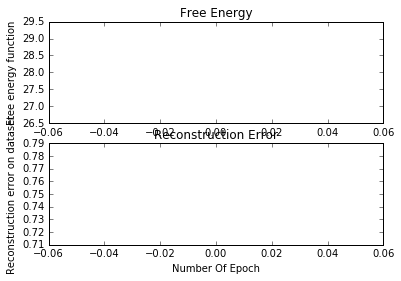

In [33]:
theano.config.profile=True

#initialize the learner and set custom kernels
x = CRBM(5, 2, 1, 1)

# design data
print "Motifs:"
print x.motifs.get_value()
kernel1 = np.tile(np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,0]]), [1,1,1])
kernel1_ = np.tile(np.flipud(np.fliplr(kernel1[0])),[1,1,1])
kernel2 = np.tile(np.array([[0,0,0],[0,0,0],[1,1,1],[0,0,0]]), [1,1,1])
kernel2_ = np.tile(np.flipud(np.fliplr(kernel2[0])), [1,1,1])
kernel3 = np.random.rand(1,4,3)
kernel3_ = np.tile(np.flipud(np.fliplr(kernel3[0])), [1,1,1])
kernel = np.array([kernel1, kernel1_])#, kernel2, kernel2_, kernel3, kernel3_])
#kernel = np.array([kernel3, kernel3_])
print "Kernel: " + str(kernel)

# initialize the data
randSeq1 = getMatrixFromSeq(Seq("ACGTGGGG", IUPAC.unambiguous_dna))
randSeq2 = getMatrixFromSeq(Seq("ACGTACGT", IUPAC.unambiguous_dna))
data = np.array([randSeq1, randSeq2], dtype=np.float32)
print "Data shape: " + str(data.shape)
x.setCustomKernels(kernel)
print data

# add the observers for free energy (test and train)
free_energy_observer = FreeEnergyObserver(x, data)
x.addObserver(free_energy_observer)

# add the observers for reconstruction error (test and train)
reconstruction_observer = ReconstructionErrorObserver(x, data)
x.addObserver(reconstruction_observer)


# perform training on our test data
start = time.time()
scores = x.trainMinibatch(data, data, 1, 1, 1)
print "Training (with compilation) performed in: " + str(time.time()-start) + " seconds."
print "Result from training: "
print "----------------------"
print "Learned Motif: "
print x.motifs.get_value()
print "Learned Bias (b): "
print x.bias.get_value()
print "Learned Constant (c): "
print x.c.get_value()

with open('test.pkl', 'w') as f:
    cPickle.dump(x, f)

plt.subplot(2,1,1)
plt.ylabel('Free energy function')
plt.xlabel('Number Of Epoch')
plt.title('Free Energy')
plt.plot(free_energy_observer.scores)

plt.subplot(2,1,2)
plt.ylabel('Reconstruction error on dataset')
plt.xlabel('Number Of Epoch')
plt.title('Reconstruction Error')
plt.plot(reconstruction_observer.scores)

In [34]:
theano.config.mode='FAST_RUN'
learner = CRBM(3, 20, 0.0000001, 2)
f = learner.getFreeEnergyFunction()
x = f(trainingData)
print trainingData.shape
print x

(15000, 1, 4, 150)
12065.2451172


## Part 4: Test our GPU solution on the "real" training set
It's time now to test on some real data to see how good the training is.

data shape: (5000, 1, 4, 150)
data shape: (15000, 1, 4, 150)
data shape: (5000, 1, 4, 150)
data shape: (15000, 1, 4, 150)
Data mat shape: (15000, 1, 4, 150)
BatchSize: 50
Num of iterations per epoch: 300
Start compiling Theano training function...
Compilation of Theano training function finished in 7.32704401016 seconds
Start training the model...
Score of function: 12517.0162109
Score of function: 12517.1202474
Score of function: 0.610805333455
Score of function: 0.610690221151
[Epoch 0] done!
Score of function: 12498.7357422
Score of function: 12498.8302083
Score of function: 0.610761332194
Score of function: 0.610985334608
[Epoch 1] done!
Score of function: 12487.7808594
Score of function: 12487.8660807
Score of function: 0.611029337565
Score of function: 0.61004844496
[Epoch 2] done!
Score of function: 12480.5978516
Score of function: 12480.6723958
Score of function: 0.610948003133
Score of function: 0.610447553847
[Epoch 3] done!
Score of function: 12487.1794922
Score of function:

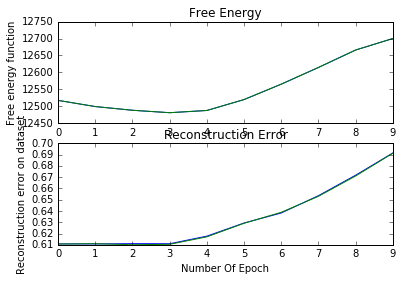

In [35]:
theano.config.mode='FAST_RUN'
theano.config.profile=True

learner = CRBM(3, 20, 0.001, 2)

# add the observers for free energy (test and train)
free_energy_observer = FreeEnergyObserver(learner, testingData)
learner.addObserver(free_energy_observer)
free_energy_observer_train = FreeEnergyObserver(learner, trainingData)
learner.addObserver(free_energy_observer_train)

# add the observers for reconstruction error (test and train)
reconstruction_observer = ReconstructionErrorObserver(learner, testingData)
learner.addObserver(reconstruction_observer)
reconstruction_observer_train = ReconstructionErrorObserver(learner, trainingData)
learner.addObserver(reconstruction_observer_train)

print "Data mat shape: " + str(trainingData.shape)
start = time.time()
learner.trainMinibatch(trainingData, testingData, 10, 50, 1)
print "Training of " + str(trainingData.shape[0]) + " performed in: " + str(time.time()-start) + " seconds."

plt.subplot(2,1,1)
plt.ylabel('Free energy function')
plt.xlabel('Number Of Epoch')
plt.title('Free Energy')
plt.plot(free_energy_observer.scores)
plt.plot(free_energy_observer_train.scores)

plt.subplot(2,1,2)
plt.ylabel('Reconstruction error on dataset')
plt.xlabel('Number Of Epoch')
plt.title('Reconstruction Error')
plt.plot(reconstruction_observer.scores)
plt.plot(reconstruction_observer_train.scores)

### Test how one could implement the derivatives for both strands
We want the derivative of the data and model to not be independent from each other.
So we have to do the following:
* Go through the different kernels and sum pairs of even and uneven kernels together (diff. strands)
* Once that is done, we have to set the uneven rows to the reverse complement of the even rows
* It all has to be in theano and efficient


In [48]:
idxes = T.ivector("indices")
output_model = T.matrix("output_model")

def sumWithNext(idx, output_model):
    sub1 = output_model[idx]
    sub2 = output_model[idx+1]
    out1 = T.set_subtensor(sub1, sub1 + sub2)
    return out1


result, updates = theano.scan(fn=sumWithNext,
                              outputs_info=output_model,
                              sequences=[idxes])

sumItUp = theano.function(inputs=[idxes, output_model], outputs=result)

def setToReverseComplement(idx, output_model):
    sub1 = output_model[idx]
    revCom = output_model[idx-1][::-1]
    return T.set_subtensor(sub1, revCom)

result, updates = theano.scan(fn=setToReverseComplement,
                              outputs_info=output_model,
                              sequences=[idxes])

revertIt = theano.function(inputs=[idxes, output_model], outputs=result)

# test
test_locations = np.asarray([0, 2], dtype=np.int32)
test_output_model = np.eye(4, 5, dtype=np.float32)
x = sumItUp(test_locations, test_output_model)[-1]
#print x
res = revertIt(test_locations + 1, x)[-1]
print res

[[ 1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  0.]]


### Now do this for the correct dimensionality (tensor4)

In [299]:
idxes = T.ivector("indices")
output_model = T.tensor4("output_model")

def sumWithNext(idx, output_model):
    sub1 = output_model[:,idx,:,:]
    sub2 = output_model[:,idx+1,:,:]
    added = sub1 + sub2
    out1 = T.set_subtensor(sub1, added)
    return out1


result, updates = theano.scan(fn=sumWithNext,
                              outputs_info=output_model,
                              sequences=[idxes])

sumItUp = theano.function(inputs=[idxes, output_model], outputs=result)

def setToReverseComplement(idx, output_model):
    sub1 = output_model[:,idx,:,:]
    revCom = output_model[:,idx-1,:,:]
    revCom = revCom[:,::-1,::-1]
    return T.set_subtensor(sub1, revCom)

result, updates = theano.scan(fn=setToReverseComplement,
                              outputs_info=output_model,
                              sequences=[idxes])

revertIt = theano.function(inputs=[idxes, output_model], outputs=result)

# test
test_locations = np.asarray([0, 2], dtype=np.int32)
test_output_model = np.random.rand(2, 4, 4, 6).astype(np.float32)
x = sumItUp(test_locations, test_output_model)[-1]
#print x
res = revertIt(test_locations + 1, x)[-1]
print res

[[[[ 0.53  1.49  1.17  1.7   1.18  1.39]
   [ 1.28  0.46  1.2   0.85  0.29  0.91]
   [ 0.14  0.29  1.26  0.85  1.    0.93]
   [ 0.62  1.38  1.38  1.    0.72  1.76]]

  [[ 1.76  0.72  1.    1.38  1.38  0.62]
   [ 0.93  1.    0.85  1.26  0.29  0.14]
   [ 0.91  0.29  0.85  1.2   0.46  1.28]
   [ 1.39  1.18  1.7   1.17  1.49  0.53]]

  [[ 0.33  0.79  1.04  0.39  0.9   0.59]
   [ 1.26  0.73  1.12  1.3   0.49  1.05]
   [ 1.45  0.85  1.03  1.23  0.64  0.91]
   [ 1.14  0.87  0.98  0.32  1.09  0.41]]

  [[ 0.41  1.09  0.32  0.98  0.87  1.14]
   [ 0.91  0.64  1.23  1.03  0.85  1.45]
   [ 1.05  0.49  1.3   1.12  0.73  1.26]
   [ 0.59  0.9   0.39  1.04  0.79  0.33]]]


 [[[ 1.74  1.05  0.92  1.12  0.45  0.62]
   [ 0.91  0.21  1.72  0.92  0.54  0.76]
   [ 1.66  1.19  0.87  1.77  1.31  1.64]
   [ 1.42  1.05  0.66  0.81  0.73  0.94]]

  [[ 0.94  0.73  0.81  0.66  1.05  1.42]
   [ 1.64  1.31  1.77  0.87  1.19  1.66]
   [ 0.76  0.54  0.92  1.72  0.21  0.91]
   [ 0.62  0.45  1.12  0.92  1.05  1.74]]

  

In [36]:
test = CRBM(4, 2, 0.01, 1)
#derivatives = np.tile(np.eye(4,4), [1,4,1,1])
derivatives = np.random.rand(1,4,4,4)
print derivatives.shape
print derivatives
k=2
print np.arange(start=0, stop=2*k, step=2)
print np.arange(start=1, stop=2*k, step=2)

der = T.tensor4('derivatives')
x = test.makeDerivativesStrandCompliant(der)
f = theano.function([der], x, allow_input_downcast=True)
result = f(derivatives)
print "RESULT"
print result

(1, 4, 4, 4)
[[[[ 0.84  0.71  0.38  0.18]
   [ 0.04  0.27  0.87  0.47]
   [ 0.97  0.06  0.35  0.58]
   [ 0.15  0.07  0.76  0.89]]

  [[ 0.03  0.53  0.12  0.43]
   [ 0.96  0.21  0.36  0.68]
   [ 0.46  0.72  0.11  0.27]
   [ 0.72  0.17  0.42  0.52]]

  [[ 0.55  0.71  0.26  0.88]
   [ 0.53  0.37  0.83  0.81]
   [ 0.28  0.48  0.07  0.32]
   [ 0.28  0.77  0.79  0.08]]

  [[ 0.05  0.43  0.16  0.47]
   [ 0.04  0.92  0.54  0.07]
   [ 0.21  0.82  0.91  0.07]
   [ 0.41  0.62  0.19  0.88]]]]
[0 2]
[1 3]
RESULT
[[[[ 0.87  1.24  0.5   0.61]
   [ 1.    0.48  1.23  1.15]
   [ 1.43  0.78  0.45  0.85]
   [ 0.87  0.24  1.18  1.41]]

  [[ 1.41  1.18  0.24  0.87]
   [ 0.85  0.45  0.78  1.43]
   [ 1.15  1.23  0.48  1.  ]
   [ 0.61  0.5   1.24  0.87]]

  [[ 0.6   1.14  0.42  1.35]
   [ 0.57  1.29  1.38  0.89]
   [ 0.49  1.3   0.99  0.39]
   [ 0.69  1.39  0.97  0.96]]

  [[ 0.96  0.97  1.39  0.69]
   [ 0.39  0.99  1.3   0.49]
   [ 0.89  1.38  1.29  0.57]
   [ 1.35  0.42  1.14  0.6 ]]]]


In [315]:
k = 2
print np.arange(start=0, stop=2*k, step=2)
print np.arange(start=1, stop=2*k, step=2)

[0 2]
[1 3]


In [89]:
# test loading
with open('test.pkl', 'r') as f:
    test = cPickle.load(f)
    
print test.motifs.get_value()

[[[[  1.00000000e+00   0.00000000e+00   0.00000000e+00]
   [ -3.44700809e-03   1.00000000e+00   0.00000000e+00]
   [  5.47764311e-03   3.56943603e-03   1.00480831e+00]
   [ -6.69240952e-04  -2.20805407e-03  -3.44700809e-03]]]


 [[[ -3.44700809e-03  -2.20805407e-03  -6.69240952e-04]
   [  1.00480831e+00   3.56943603e-03   5.47764311e-03]
   [  0.00000000e+00   1.00000000e+00  -3.44700809e-03]
   [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]]]
